# Dutch Corpora

In [1]:
# Install tempo-embeddings from GitHub
# This can also refer to a specific version or branch

#%pip install --upgrade pip  # Required for properly resolving dependencies
#%pip uninstall -y tempo_embeddings  # Remove existing installation
#%pip install --upgrade git+https://github.com/Semantics-of-Sustainability/tempo-embeddings.git
%pip install -e ../ # to pull the "local" tempo embeddings and automatically register code changes when debugging

Obtaining file:///Users/jose/Repos/tempo-embeddings
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for tempo_embeddings (pyproject.toml) ... done
  Created wheel for tempo_embeddings: filename=tempo_embeddings-0.0.1-0.editable-py3-none-any.whl size=8963 sha256=ecdacb52c07c25ed9db5aa7f610119b93558b56989e3d8a259573ec192925e64
  Stored in directory: /private/var/folders/79/zf67ls7520x9m4mj7nx6q07w0000gp/T/pip-ephem-wheel-cache-ovvs68ls/wheels/de/25/96/d92b7a130b730e0ab67770d76841f36cb3d1f9cda32a4a539b
Successfully built tempo_embeddings
  Attempting uninstall: tempo_embeddings
    Found existing installation: tempo_embeddings 0.0.1
    Uninstalling tempo_embeddings-0.0.1:
      Successfully uninstalled tempo_embeddings-0.0.1
Note: you may need to restart the kernel to use updated packages.
Note: you may need to

In [2]:
# make sure installation has succeeded
import tempo_embeddings

In [3]:
%load_ext autoreload

In [4]:
try:
    import google.colab

    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False

## Load Data

The data needs to be downloaded and provided in the path configured in the next cell.

NOTE: You have to manually adapt the `DATA_DIR` below.

In [5]:
%autoreload now

import operator
from functools import reduce
from pathlib import Path
from tqdm import tqdm
from tempo_embeddings.text.corpus import Corpus

/Users/jose/Repos/tempo-embeddings/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jose/Repos/tempo-embeddings/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
WINDOW_SIZE = 200

RANDOM_SAMPLE_ANP = 200
RANDOM_SAMPLE_STATEN_GENERAAL = 200

STATEN_GENERAAL_BLACKLIST = ["1987"]

FILTER_TERMS = ["duurzaam"]  # Search term(s) for filtering the corpus

In [7]:
## NOTE: Adapt the `DATA_DIR` below manually!
## For a shared Google Drive, create a shortcut into your own Google Drive
## See https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab

LOCAL_PATHS: list[Path] = [
    Path.home() / "Documents" / "SemanticsOfSustainability" / "data" / "Joris",
    Path.home() / "SEED_DATA" / "SemanticsSustainability", # local angel
    Path("/data/volume_2/data"),  # Research Cloud
    Path("/home/cschnober/data/"),  # Snellius
]

if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

    DATA_DIR = Path("/content/drive/MyDrive/Data/")
else:
    try:
        DATA_DIR = next(path for path in LOCAL_PATHS if path.is_dir())
    except StopIteration as e:
        raise DirectoryNotFoundError(f"Data directory not found.") from e

assert DATA_DIR.is_dir(), f"Data dir '{DATA_DIR}' not found."

### ANP

In [8]:
ANP_DIR = DATA_DIR / "ANP"
assert RANDOM_SAMPLE_ANP == 0 or ANP_DIR.is_dir(), f"{ANP_DIR} not found."

In [9]:
import random


random.seed(0)

anp_files = list(ANP_DIR.glob("ANP_????.csv.gz"))

if RANDOM_SAMPLE_ANP and len(anp_files) > RANDOM_SAMPLE_ANP:
    anp_files = random.sample(
        list(ANP_DIR.glob("ANP_????.csv.gz")), k=RANDOM_SAMPLE_ANP
    )

print(f"Found {len(anp_files)} ANP Files")
anp_files[:10]

Found 2 ANP Files


[PosixPath('/Users/jose/SEED_DATA/SemanticsSustainability/ANP/ANP_1983.csv.gz'),
 PosixPath('/Users/jose/SEED_DATA/SemanticsSustainability/ANP/ANP_1984.csv.gz')]

In [10]:
anp_corpus = (
    reduce(
        operator.add,
        (
            Corpus.from_csv_file(
                path,
                filter_terms=FILTER_TERMS,
                text_columns=["content"],
                encoding="iso8859_15",
                compression="gzip",
                delimiter=";",
                window_size=WINDOW_SIZE,
            )
            for path in tqdm(anp_files, unit="file")
        ),
    )
    if anp_files
    else Corpus()
)

len(anp_corpus)

100%|██████████| 2/2 [00:01<00:00,  1.79file/s]


55

### Staten Generaal

In [11]:
STATEN_GENERAAL_DIR = DATA_DIR / "StatenGeneraal"

assert RANDOM_SAMPLE_STATEN_GENERAAL == 0 or STATEN_GENERAAL_DIR.is_dir()

In [12]:
glob195x = "StatenGeneraal_19[0-9]?.csv.gz"  # Pattern for files from 1950-1999
glob20xx = "StatenGeneraal_2???.csv.gz"  # Pattern for files from 2000

files_195x = list(STATEN_GENERAAL_DIR.glob(glob195x))
files_20xx = list(STATEN_GENERAAL_DIR.glob(glob20xx))

sg_files = [
    file
    # Merge files from patterns
    for file in files_20xx + files_195x
    # Remove blacklisted files:
    for blacklisted in STATEN_GENERAAL_BLACKLIST
    if blacklisted not in file.name
]

if RANDOM_SAMPLE_STATEN_GENERAAL and RANDOM_SAMPLE_STATEN_GENERAAL < len(sg_files):
    sg_files = random.sample(sg_files, k=RANDOM_SAMPLE_STATEN_GENERAAL)

print(f"Found {len(sg_files)} STAATEN_G Files")
sorted(sg_files[:10])

Found 2 STAATEN_G Files


[PosixPath('/Users/jose/SEED_DATA/SemanticsSustainability/StatenGeneraal/StatenGeneraal_2017.csv.gz'),
 PosixPath('/Users/jose/SEED_DATA/SemanticsSustainability/StatenGeneraal/StatenGeneraal_2018.csv.gz')]

In [13]:
%autoreload now

import csv

csv.field_size_limit(100000000)

sg_corpus = (
    reduce(
        operator.add,
        (
            Corpus.from_csv_file(
                path,
                filter_terms=FILTER_TERMS,
                text_columns=["Content"],
                encoding="utf-8",
                compression="gzip",
                delimiter=";",
                window_size=WINDOW_SIZE,
            )
            for path in tqdm(sg_files, unit="file")
        ),
    )
    if sg_files
    else Corpus()
)

len(sg_corpus)

100%|██████████| 2/2 [00:01<00:00,  1.18file/s]


1512

In [14]:
for p in sg_corpus.passages[:20]:
    print(len(p), p)

210 Passage('economische groei consequent milieuvernietiging op, in meerdere of mindere mate. Economische groei zou "duurzaam" te noemen zijn als die wordt gekoppeld aan technologische vooruitgang en toenemende efficiëntie.', {'': '204', 'RecId': 'h-ek-20162017-14-3', 'chamber': 'EersteKamer', 'date': '2017-01-17', 'speakers': 'De voorzitter :|Mevrouw Teunissen ( PvdD ):|Mevrouw Vos ( GroenLinks ):|De heer Van Hattem ( PVV ):|Mevrouw Stienen ( D66 ):|De heer Verheijen ( PvdA ):|Mevrouw Meijer ( SP ):|De voorzitter :|Minister Schultz van Haegen-Maas Geesteranus :|Mevrouw Vos ( GroenLinks ):|Minister Schultz van Haegen-Maas Geesteranus :|Mevrouw Vos ( GroenLinks ):|Minister Schultz van Haegen-Maas Geesteranus :|De heer Verheijen ( PvdA ):|Minister Schultz van Haegen-Maas Geesteranus :|De heer Verheijen ( PvdA ):|Minister Schultz van Haegen-Maas Geesteranus :|De heer Van Hattem ( PVV ):|Minister Schultz van Haegen-Maas Geesteranus :|De heer Van Hattem ( PVV ):|Minister Schultz van Haegen-

### Merge

In [15]:
corpus = anp_corpus + sg_corpus
len(corpus)

1567

## Load Model

In [16]:
%autoreload now

LAYER = 9

from tempo_embeddings.embeddings.model import (
    RobertaModelWrapper,
    TransformerModelWrapper,
    XModModelWrapper,
    SentenceTransformerModelWrapper,
)

kwargs = {"accelerate": True}

### RoBERTa Models
# MODEL_NAME = "DTAI-KULeuven/robbertje-1-gb-non-shuffled"
# model_class = RobertaModelWrapper

### XMod Models
# MODEL_NAME = "facebook/xmod-base"
# kwargs["default_language"] = "nl_XX"
# model_class = XModModelWrapper

### BERT Models
# MODEL_NAME = "GroNLP/bert-base-dutch-cased"
# MODEL_NAME = "xlm-roberta-base"
# MODEL_NAME = "xlm-mlm-100-1280"
# model_class = TransformerModelWrapper

### Sentence Transformers
MODEL_NAME = "NetherlandsForensicInstitute/robbert-2022-dutch-sentence-transformers"
# MODEL_NAME = "textgain/allnli-GroNLP-bert-base-dutch-cased"
model_class = SentenceTransformerModelWrapper

model = model_class.from_pretrained(MODEL_NAME, layer=LAYER, **kwargs)
model

## Create or Open existing Database

In [17]:
EMBED_CONFIG = {"type":"custom"}

from tempo_embeddings.embeddings.vector_database import ChromaDatabaseManager
db_custom = ChromaDatabaseManager(db_path="testing_db_custom", embedder_name=MODEL_NAME,embedder_config=EMBED_CONFIG, batch_size=10)
db_custom.connect()

collection_name = "anp_sg_corpus"
loaded_existing_collection = False

anp_sg_collection = db_custom.create_new_collection(collection_name)
if not anp_sg_collection:
    anp_sg_collection = db_custom.get_existing_collection(collection_name)
    loaded_existing_collection = True

## Compute & Save Embeddings (If DB didn't existed)

In [18]:
%autoreload now

from tempo_embeddings.embeddings.model import EmbeddingsMethod

if not loaded_existing_collection:
    model.batch_size = 128
    model.embeddings_method = EmbeddingsMethod.MEAN

    embeds = model.compute_embeddings(corpus)
    embeddings_full, embeddings_xy = embeds["embeddings_full"], embeds["embeddings_xy"]
    db_custom.insert_passages_embeddings(anp_sg_collection, corpus.passages, embeddings_full)
    corpus.embeddings = embeddings_xy
else:
    # This hack should be improved. We need to re-think the whole tokenization process...
    for p in corpus.passages:
        p.tokenization = db_custom._tokenize(p.text)
    # Generate 2-Dim Embeddings that will be clustered later
    two_dim_embeddings = db_custom.compress_embeddings(anp_sg_collection, persist_in_db=True)
    if two_dim_embeddings is not None:
        corpus.embeddings = two_dim_embeddings
        print(len(corpus.embeddings))

Embeddings: 100%|██████████| 13/13 [00:10<00:00,  1.27batch/s]


UMAP( verbose=True)
Mon Feb  5 10:26:44 2024 Construct fuzzy simplicial set
Mon Feb  5 10:26:45 2024 Finding Nearest Neighbors
Mon Feb  5 10:26:46 2024 Finished Nearest Neighbor Search
Mon Feb  5 10:26:47 2024 Construct embedding


Epochs completed:  50%| ████▉      248/500 [00:01]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs


Epochs completed:  98%| █████████▊ 491/500 [00:01]

	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:01]


Mon Feb  5 10:26:48 2024 Finished embedding


Embeddings Batches: 100%|██████████| 157/157 [00:01<00:00, 108.95batch/s]

Added 1567 new documents. Total = 1567


## TESTS: Retrieve Records from Database

In [19]:
%autoreload now

records = db_custom.get_records(anp_sg_collection, filter_words=["toekomst"], where_obj={'$and': [{'year': {'$eq': '1983'}}, {'month': {'$eq': '7'}}]})

print(records["ids"])

for x in records["documents"][:10]:
    print(x)
    print(db_custom.is_in_collection(anp_sg_collection, x))
    print(db_custom.get_vector_from_db(anp_sg_collection, x))
    print(db_custom.embed_text_batch([x]))
    print("-----")

print(len(records["ids"]))
print([len(x) for x in corpus.embeddings[:10]])

['-1842601457653453354', '-2278999730748971713', '-3795242019866769108', '-9112571470192619903', '649723421280183947']
de aannemers  toch niet op een duurzaam herstel in de nabije toekomst. Het  7.  aantal bouwvergunningen en een enquête onder architecten wijzen  niet in die richting.  10  11  12  13.  14.  15.  Bron:
True
[0.7433292865753174, 0.10059642046689987, 0.08088227361440659, -0.13089588284492493, 0.4015079140663147, -0.22537004947662354, 0.4562278985977173, -0.8052078485488892, 0.002192046958953142, -0.7233903408050537, 0.32228922843933105, 0.40308359265327454, 0.31013229489326477, -0.6591715216636658, 0.4139671325683594, 0.6322245001792908, 0.1412719488143921, 0.19397923350334167, 0.20242539048194885, 0.41886863112449646, 0.022516127675771713, -0.08393397182226181, 0.7408398985862732, -0.6997169256210327, -0.22062407433986664, 0.833660900592804, -0.1688144952058792, -0.37035906314849854, 0.38721752166748047, 0.5984067320823669, 0.9494462013244629, -0.34944605827331543, 0.070

## Read Stopwords

In [20]:
!wget --continue https://raw.githubusercontent.com/Semantics-of-Sustainability/tempo-embeddings/main/tempo_embeddings/data/stopwords-filter-nl.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
zsh:1: command not found: wget


In [21]:
stopwords_file = Path("stopwords-filter-nl.txt")

with open(stopwords_file.absolute(), "rt") as f:
    stopwords = set(f.read().splitlines())

stopwords.update(
    {
        "wij",
        "we",
        "moeten",
        "heer",
        "mevrouw",
        "minister",
        "voorzitter",
        "gaat",
        "wel",
        "den",
    }
)

## Cluster

In [22]:
%autoreload now

# Arguments: min_cluster_size=10, cluster_selection_epsilon=0.1, ...
# See https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html for full list

# e.g. min_samples=10, cluster_selection_epsilon=0.2, cluster_selection_method="leaf"

clusters = corpus.cluster(min_cluster_size=10, cluster_selection_epsilon=0.1)
print(clusters)

[Subcorpus(0, [0, 1, 5, 6, 7, 8, 9, 10, 11, 12]), Subcorpus(-1, [2, 3, 4, 23, 24, 25, 65, 67, 71, 72]), Subcorpus(22, [55, 56, 63, 68, 76, 79, 81, 82, 83, 85]), Subcorpus(7, [57, 58, 59, 60, 162, 180, 181, 182, 183, 229]), Subcorpus(15, [61, 64, 66, 137, 142, 301, 302, 304, 305, 306]), Subcorpus(17, [62, 143, 144, 191, 192, 443, 590, 669, 803, 905]), Subcorpus(8, [69, 70, 80, 296, 342, 460, 461, 469, 471, 472]), Subcorpus(20, [73, 199, 364, 390, 485, 793, 821, 822, 842, 849]), Subcorpus(21, [74, 114, 118, 232, 298, 374, 377, 386, 486, 749]), Subcorpus(16, [77, 78, 189, 190, 656, 657, 658, 659, 660, 662]), Subcorpus(13, [127, 129, 130, 131, 132, 133, 134, 320, 442, 446]), Subcorpus(19, [149, 166, 379, 744, 938, 1183, 1420, 1422, 1450, 1519]), Subcorpus(23, [150, 151, 155, 156, 177, 388, 389, 565, 600, 601]), Subcorpus(6, [157, 158, 1107, 1108, 1109, 1132, 1133, 1221, 1239, 1240]), Subcorpus(12, [163, 164, 262, 263, 269, 270, 271, 274, 275, 284]), Subcorpus(4, [173, 175, 205, 207, 212, 2

In [23]:
for cluster in clusters:
    cluster.set_topic_label(exclude_words=frozenset(stopwords | set(FILTER_TERMS)), n=5)
    print(cluster)

Subcorpus('herstel; wereldeconomie; red; tijd; dsm', [0, 1, 5, 6, 7, 8, 9, 10, 11, 12])
Subcorpus('Outliers', [2, 3, 4, 23, 24, 25, 65, 67, 71, 72])
Subcorpus('duurzaamheid; nederland; goed; heel; willen', [55, 56, 63, 68, 76, 79, 81, 82, 83, 85])
Subcorpus('gepubliceerd; rondgezonden; 2018; 2017; funderingsherstel', [57, 58, 59, 60, 162, 180, 181, 182, 183, 229])
Subcorpus('verduurzaamd; woningen; corporaties; duurzaamheid; maken', [61, 64, 66, 137, 142, 301, 302, 304, 305, 306])
Subcorpus('spreker; eerste; duurzaamheid; vao; vraagt', [62, 143, 144, 191, 192, 443, 590, 669, 803, 905])
Subcorpus('werk; mensen; zorg; participatiewet; inkomen', [69, 70, 80, 296, 342, 460, 461, 469, 471, 472])
Subcorpus('gas; nederland; 2050; denken; duurt', [73, 199, 364, 390, 485, 793, 821, 822, 842, 849])
Subcorpus('energie; duurzame; aandeel; opgewekte; vermogen', [74, 114, 118, 232, 298, 374, 377, 386, 486, 749])
Subcorpus('duurzaamheid; economie; onderwijs; vak; vorming', [77, 78, 189, 190, 656, 657

/Users/jose/Repos/tempo-embeddings/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [24]:
with open("clusters.txt", "wt") as f:
    for cluster in clusters:
        print(
            ", ".join(
                cluster.top_words(
                    exclude_words=frozenset(stopwords | set(FILTER_TERMS)), n=5
                )
            ),
            file=f,
        )

# Visualize Embeddings

<Axes: xlabel='x', ylabel='y'>

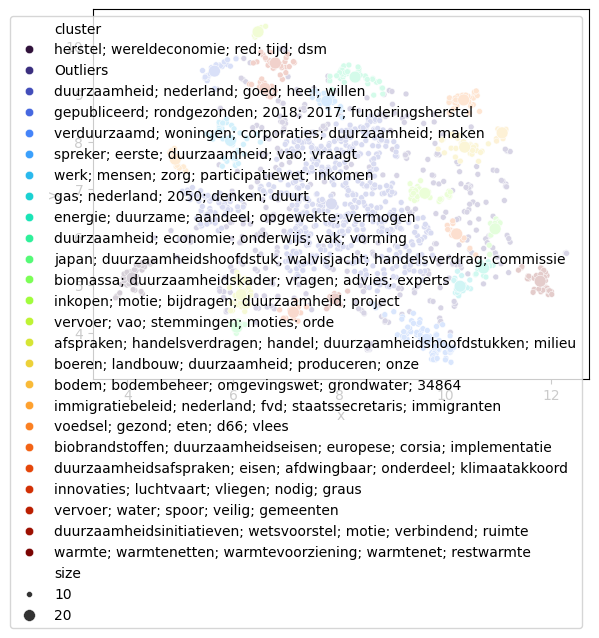

In [25]:
%autoreload now

from tempo_embeddings.visualization.clusters import ClusterVisualizer

visualizer = ClusterVisualizer(*clusters)
visualizer.visualize()

In [26]:
import os
from bokeh.io import output_notebook
from bokeh.io import reset_output
from bokeh.plotting import show
from tempo_embeddings.visualization.bokeh import BokehInteractiveVisualizer


output_notebook()
# reset_output()

visualizer = BokehInteractiveVisualizer(
    *clusters, metadata_fields=corpus.metadata_fields(), width=2000, height=1000
)

os.environ[
    "BOKEH_ALLOW_WS_ORIGIN"
] = "*"#"0gvbv9d871k7g8j4h6mppna69o1qlh79dr9fepnuo1qr04mk1hbe"

# NOTE: Bookeh Runs in the 5006 PORT By default...

show(visualizer.create_document)

Loading BokehJS ...